# Short notebook 1 


### TDT4173 - Modern machine learning in practice - fall 2024 
Group number: 8 \
Group id kaggle: [8] Admiral P(redictor) \
Group members: André Virani(525432), Peder Aas Vårheim(564051) and Markus Sandnes(544087)

### Import relevant packages

In [ ]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


### Import datasets 

In [2]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")
vessels_df = pd.read_csv('data/vessels.csv', sep = '|')
ports_df = pd.read_csv('data/ports.csv', sep = '|')
ports_df['portLatitude'] = ports_df['latitude']
ports_df['portLongitude'] = ports_df['longitude']
ports_df = ports_df.drop(columns = ['latitude', 'longitude'])
test_df = pd.read_csv('data/ais_test.csv', sep = ',')   
schedules_df = pd.read_csv('data/schedules_to_may_2024.csv', sep = '|')

### Some preprocessing 

In [ ]:
train_df = pd.merge(train_df, ports_df, on = 'portId', how = 'left')

train_df = pd.merge(train_df, vessels_df[['vesselId', 'shippingLineId', ]], on = 'vesselId')
train_df = train_df.dropna()

train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])


train_df['etaRaw'] = '2024-' + train_df['etaRaw']+ ':00'
train_df['etaRaw'] = pd.to_datetime(train_df['etaRaw'], errors = 'coerce')
train_df['time_to_arrival'] = (train_df['etaRaw'] - train_df['time']).dt.total_seconds()
train_df['distance_to_port_latitude'] = train_df['latitude'] - train_df['portLatitude']
train_df['distance_to_port_longitude'] = train_df['longitude'] - train_df['portLongitude']


timestamps = train_df[['time', 'vesselId']]

train_df = train_df.drop(columns = ['countryName', 'ISO', 'UN_LOCODE', 'name', 'portLocation', ])

### Label encoding

In [4]:

le_vesselid = LabelEncoder()
all_vesselId = pd.concat([train_df['vesselId'], schedules_df['vesselId']], axis = 0)
le_vesselid.fit(all_vesselId)
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])
schedules_df['vesselId'] = le_vesselid.transform(schedules_df['vesselId'])

le_shippingLineId = LabelEncoder()
all_shippingLineId = pd.concat([train_df['shippingLineId'], schedules_df['shippingLineId']], axis = 0)
le_shippingLineId.fit(all_shippingLineId)
train_df['shippingLineId'] = le_shippingLineId.transform(train_df['shippingLineId'])
schedules_df['shippingLineId'] = le_shippingLineId.transform(schedules_df['shippingLineId'])

le_portid = LabelEncoder()
le_portid.fit(train_df['portId'])
train_df['portId'] = le_portid.transform(train_df['portId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes


Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId', 'portLatitude', 'portLongitude',
       'shippingLineId', 'time_to_arrival', 'distance_to_port_latitude',
       'distance_to_port_longitude'],
      dtype='object')


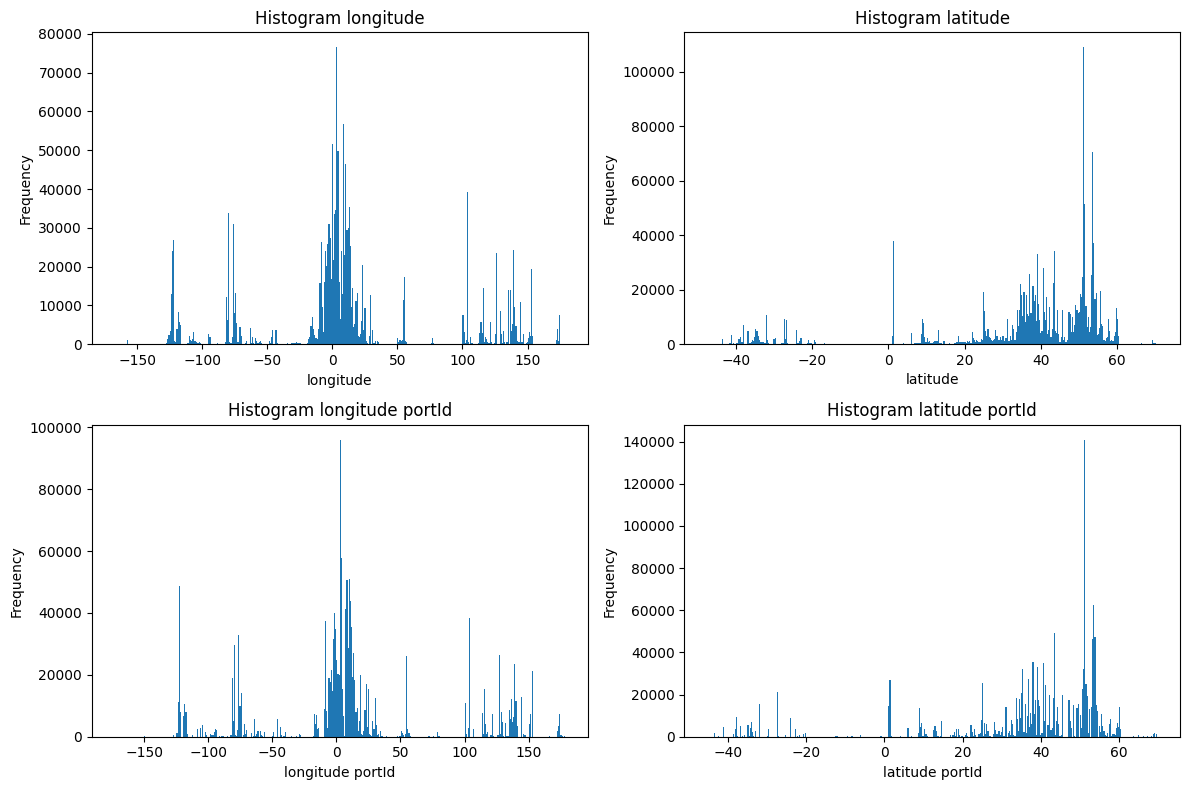

In [5]:
print(train_df.columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['longitude'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram longitude', xlabel = 'longitude')

train_df['latitude'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram latitude', xlabel = 'latitude')

train_df['portLongitude'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram longitude portId', xlabel= 'longitude portId')

train_df['portLatitude'].plot(kind='hist', bins=400, ax=axes[1,1], title='Histogram latitude portId', xlabel = 'latitude portId')

plt.tight_layout()
plt.show()


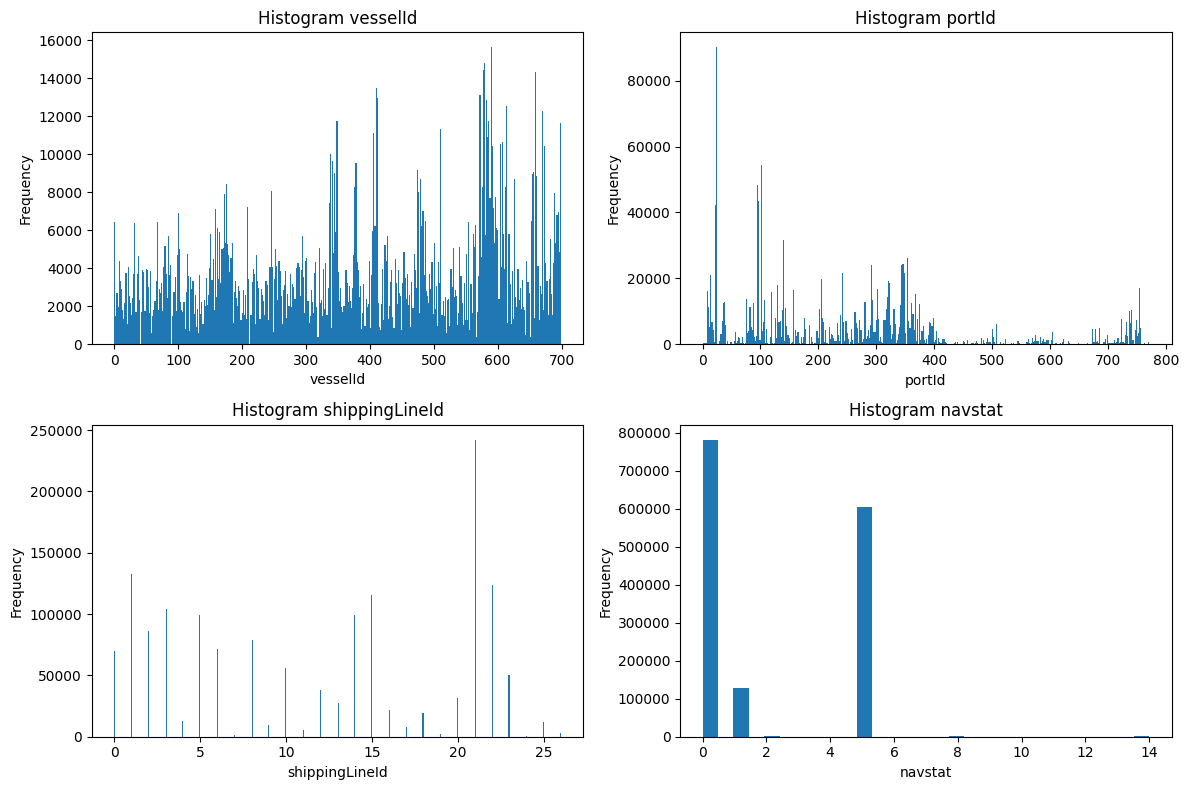

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['vesselId'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram vesselId', xlabel = 'vesselId')

train_df['portId'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram portId', xlabel = 'portId')

train_df['shippingLineId'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram shippingLineId', xlabel= 'shippingLineId')

train_df['navstat'].plot(kind='hist', bins=29, ax=axes[1,1], title='Histogram navstat', xlabel= 'navstat')


plt.tight_layout()
plt.show()


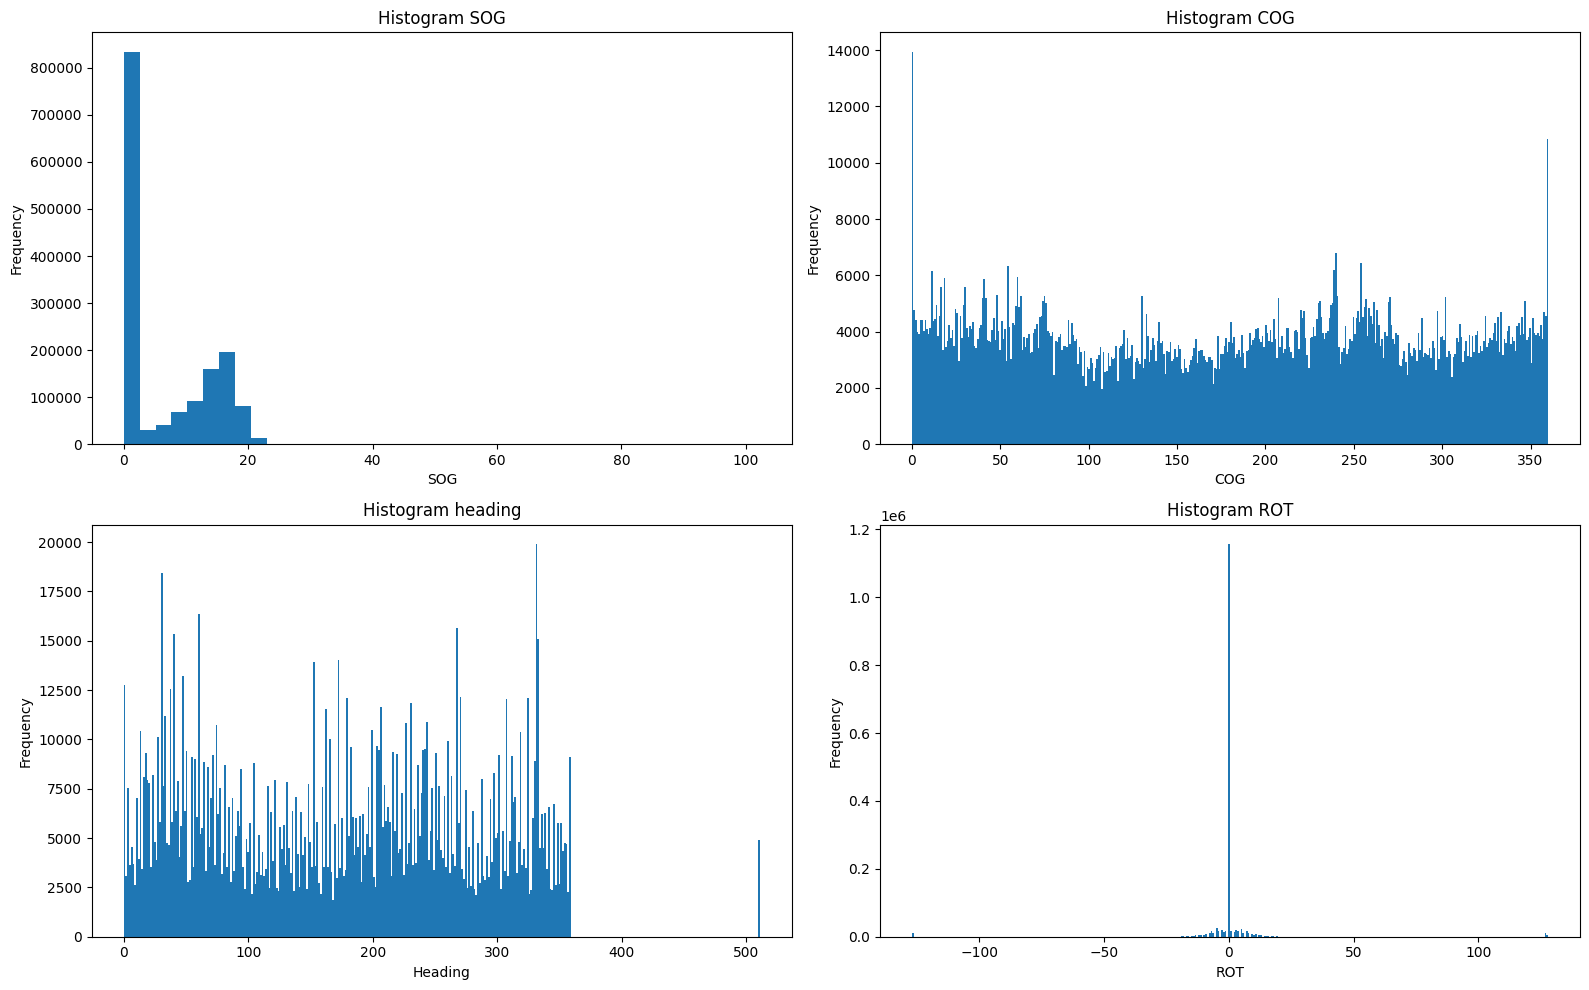

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

train_df['sog'].plot(kind='hist', bins=40, ax=axes[0,0], title='Histogram SOG', xlabel = 'SOG')

train_df['cog'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram COG', xlabel = 'COG')

train_df['heading'].plot(kind='hist', bins=360, ax=axes[1,0], title='Histogram heading', xlabel = 'Heading')

train_df['rot'].plot(kind='hist', bins=360, ax=axes[1,1], title='Histogram ROT', xlabel= 'ROT')

plt.tight_layout()
plt.show()

### Feature engineering
First for the training set

In [36]:
X_train = train_df.copy()
X_train[['time_y', 'longitude_y', 'latitude_y']] = (X_train[['time', 'vesselId', 'longitude', 'latitude']].groupby(by = 'vesselId').shift(-1))
X_train['vesselId'] = X_train['vesselId']
X_train['time_diff'] =  (X_train['time_y'] - X_train['time']).dt.total_seconds()
X_train = X_train.dropna()
for k in [1,2,3, 4, 5, 6, 7, 8]:
    print(k , end = '\r')
    X_k = train_df.copy()
    X_k[['time_y', 'longitude_y', 'latitude_y']] = (X_k[['time', 'vesselId', 'longitude', 'latitude']].groupby(by = 'vesselId').shift(-2**k))
    X_k['vesselId'] = train_df['vesselId']
    X_k['time_diff'] =  (X_k['time_y'] - X_k['time']).dt.total_seconds()
    X_k = X_k.dropna()
    X_train = pd.concat([X_train, X_k])
display(X_train.head)

<bound method NDFrame.head of                        time    cog   sog  rot  heading  navstat  \
0       2024-01-01 00:00:25  284.0   0.7    0       88        0   
1       2024-01-01 00:00:36  109.6   0.0   -6      347        1   
2       2024-01-01 00:01:45  111.0  11.0    0      112        0   
3       2024-01-01 00:03:11   96.4   0.0    0      142        1   
4       2024-01-01 00:03:51  214.0  19.7    0      215        0   
...                     ...    ...   ...  ...      ...      ...   
1479415 2024-05-04 10:39:12   77.0  12.3    0       79        0   
1479432 2024-05-04 10:39:16  106.0  13.1    0      110        0   
1479455 2024-05-04 10:39:20  246.1   0.2    0      202        1   
1479458 2024-05-04 10:39:20   89.9  14.6   -6       88        0   
1479466 2024-05-04 10:39:21   69.7  14.4    4       71        0   

                     etaRaw  latitude  longitude  vesselId  ...  portLatitude  \
0       2024-01-09 23:00:00 -34.74370  -57.85130        54  ...    -33.587500   
1  

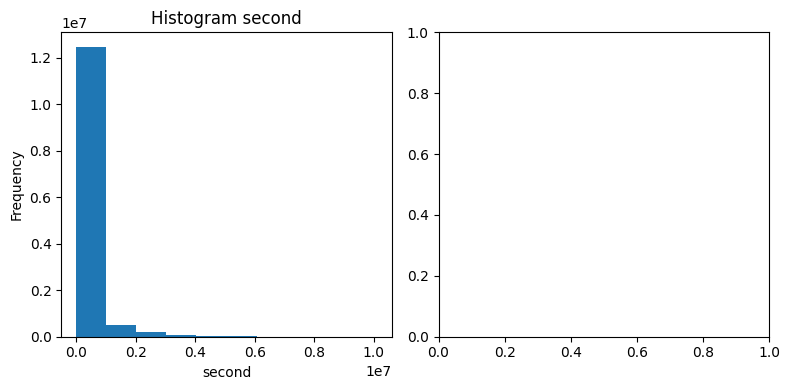

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))


X_train['time_diff'].plot(kind = 'hist', ax= ax[0], title = f'Histogram second', xlabel = f'second')


plt.tight_layout()
plt.show()

### Feature engineering 2 
For test set 

In [38]:
last_values_df = train_df.groupby('vesselId').tail(1)
merged_data = pd.merge(test_df, last_values_df, on='vesselId', how='left', suffixes=('', '_last'))
test_data = merged_data
test_data['time_x'] = test_data['time_last'].copy()
test_data['time_y'] = test_data['time'].copy()
test_data = test_data.drop(columns = ['time', 'time_last'])
test_data['time_diff'] = (pd.to_datetime(test_data['time_y']) - pd.to_datetime(test_data['time_x'])).dt.total_seconds()
test_data['time_to_arrival'] = (pd.to_datetime(test_data['time_x']) - pd.to_datetime(test_data['etaRaw'])).dt.total_seconds()
display(test_data)

,ID,vesselId,scaling_factor,latitude_predicted,longitude_predicted,cog,sog,rot,heading,navstat,...,portId,portLatitude,portLongitude,shippingLineId,time_to_arrival,distance_to_port_latitude,distance_to_port_longitude,time_x,time_y,time_diff
0,0,89,0.3,31.242449,-81.265022,179.6,0.0,0,344,5,...,374,31.140556,-81.496667,1,133396.0,0.005914,-0.001223,2024-05-07 23:48:16,2024-05-08 00:03:16,900.0
1,1,635,0.3,15.661164,119.959297,24.7,0.0,0,214,5,...,269,14.808333,120.279444,18,521836.0,0.008607,0.016806,2024-05-07 23:57:16,2024-05-08 00:06:17,541.0
2,2,606,0.3,38.425766,11.242848,8.0,18.7,0,6,0,...,130,42.098889,11.780833,21,-45952.0,-3.819939,-0.998033,2024-05-07 23:59:08,2024-05-08 00:10:02,654.0
3,3,552,0.3,-43.427086,173.019196,321.3,0.1,0,70,1,...,248,-43.606111,172.716111,15,81454.0,0.068261,0.119109,2024-05-07 23:52:34,2024-05-08 00:10:34,1080.0
4,4,1,0.3,48.290894,-6.150626,291.0,0.3,0,275,2,...,80,48.380556,-4.474167,25,-101311.0,0.152644,-1.645863,2024-05-07 23:51:29,2024-05-08 00:12:27,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,51734,52,0.1,53.625156,8.075053,5.7,15.6,0,10,0,...,95,53.563611,8.554722,0,-1289952.0,-27.334691,-87.958132,2024-04-27 21:40:48,2024-05-12 23:59:58,1304350.0
51735,51735,117,0.1,32.999691,-111.523911,87.6,14.4,0,88,0,...,181,42.988611,144.353611,1,-1204235.0,-1.348061,-1.054191,2024-04-26 13:29:25,2024-05-12 23:59:58,1420233.0
51736,51736,620,0.1,19.969406,85.699242,76.9,15.9,0,78,0,...,150,36.425278,140.621111,8,-991952.0,-1.092938,2.070039,2024-04-28 19:17:28,2024-05-12 23:59:58,1226550.0
51737,51737,584,0.1,58.101727,19.574316,232.0,22.0,-13,234,0,...,102,53.952222,10.869167,22,-85060.0,5.313488,11.120543,2024-05-07 19:22:20,2024-05-12 23:59:58,448658.0


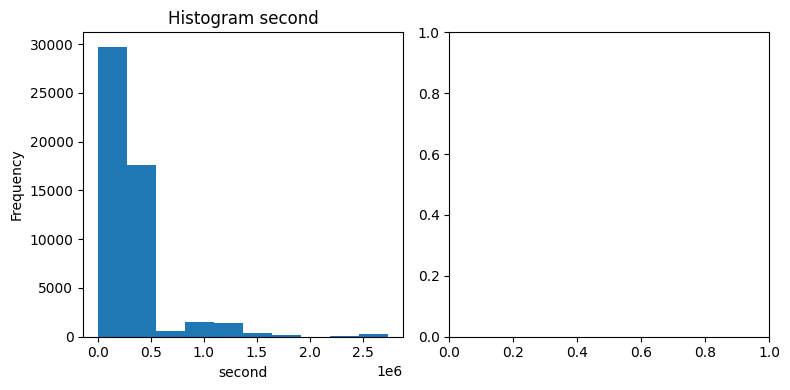

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))


test_data['time_diff'].plot(kind = 'hist', ax= ax[0], title = f'Histogram second', xlabel = f'second')


plt.tight_layout()
plt.show()

In [40]:
train_data = X_train.copy()
features =  ['time_diff', 'vesselId', 'cog', 'sog', 'heading', 'latitude', 'longitude', 'portLatitude', 'portLongitude']
targets = ['latitude_y', 'longitude_y']

x = train_data[features]
y = train_data[targets]
params = {
    'objective': 'reg:squarederror',
    'max_depth': 13,
    'eta':  0.02,
    'min_child_weight': 2,
    'subsample': 0.9,
    'n_jobs':-1
}
dtrain = xgb.DMatrix(x, label = y)
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_boost_round= 600, evals = evals, verbose_eval= 10)

[0]	train-rmse:51.34590
[10]	train-rmse:42.32015
[20]	train-rmse:34.99441
[30]	train-rmse:29.06097
[40]	train-rmse:24.26653
[50]	train-rmse:20.40162
[60]	train-rmse:17.30791
[70]	train-rmse:14.84184
[80]	train-rmse:12.88911
[90]	train-rmse:11.35795
[100]	train-rmse:10.15251
[110]	train-rmse:9.20822
[120]	train-rmse:8.46745
[130]	train-rmse:7.88086
[140]	train-rmse:7.40712
[150]	train-rmse:7.03421
[160]	train-rmse:6.73056
[170]	train-rmse:6.47956
[180]	train-rmse:6.26967
[190]	train-rmse:6.08611
[200]	train-rmse:5.93383
[210]	train-rmse:5.79586
[220]	train-rmse:5.66344
[230]	train-rmse:5.52853
[240]	train-rmse:5.40968
[250]	train-rmse:5.29393
[260]	train-rmse:5.20270
[270]	train-rmse:5.11094
[280]	train-rmse:5.02692
[290]	train-rmse:4.95433
[300]	train-rmse:4.87427
[310]	train-rmse:4.80148
[320]	train-rmse:4.73269
[330]	train-rmse:4.66097
[340]	train-rmse:4.60609
[350]	train-rmse:4.55401
[360]	train-rmse:4.50314
[370]	train-rmse:4.46160
[380]	train-rmse:4.40828
[390]	train-rmse:4.36215


In [ ]:
model.save_model('xgboost_model.json') 

{'time_diff': 1155111.0, 'vesselId': 1116552.0, 'cog': 576527.0, 'sog': 551527.0, 'heading': 454856.0, 'latitude': 509707.0, 'longitude': 432537.0, 'portLatitude': 287542.0, 'portLongitude': 196535.0}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

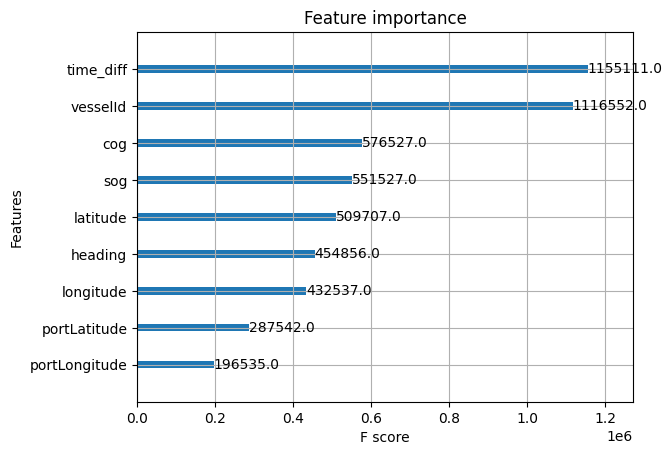

In [42]:
feature_importances = model.get_score(importance_type='weight')
print(feature_importances)
xgb.plot_importance(model)

In [43]:
test_data['vesselId'] = test_data['vesselId'].apply(lambda x: int(x))
dtest = xgb.DMatrix(test_data[features])

prediction = model.predict(dtest)

In [44]:
test_df['latitude_predicted'] = prediction[:,0]
test_df['longitude_predicted'] = prediction[:,1]

display(test_df)

submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])
submission.to_csv('submission_10_11.csv', index = False)

,ID,vesselId,time,scaling_factor,latitude_predicted,longitude_predicted
0,0,89,2024-05-08 00:03:16,0.3,31.187532,-81.297363
1,1,635,2024-05-08 00:06:17,0.3,15.243777,119.923439
2,2,606,2024-05-08 00:10:02,0.3,38.793243,11.380412
3,3,552,2024-05-08 00:10:34,0.3,-43.405991,173.005936
4,4,1,2024-05-08 00:12:27,0.3,48.269176,-6.024753
...,...,...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1,53.614925,33.609081
51735,51735,117,2024-05-12 23:59:58,0.1,35.612404,-108.816292
51736,51736,620,2024-05-12 23:59:58,0.1,21.654881,18.614731
51737,51737,584,2024-05-12 23:59:58,0.1,58.618198,21.382292


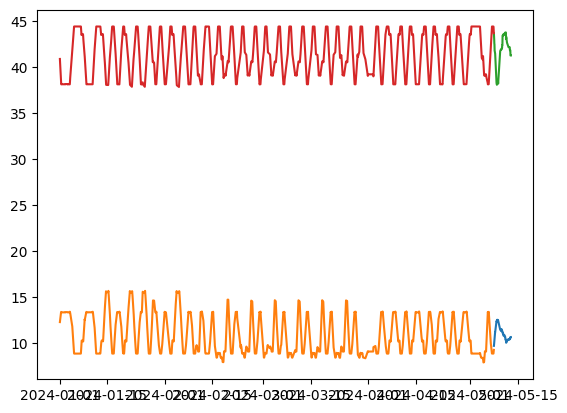

In [86]:
vessel = test_df['vesselId'].unique()[118]
vessel_data_test = test_df[test_df['vesselId'] == vessel]
vessel_data_train = train_df[train_df['vesselId'] == vessel]
plt.plot(vessel_data_test['time'],vessel_data_test['longitude_predicted'])
plt.plot(vessel_data_train['time'],vessel_data_train['longitude'])

plt.plot(vessel_data_test['time'],vessel_data_test['latitude_predicted'])
plt.plot(vessel_data_train['time'],vessel_data_train['latitude'])